# Inferencia Resnet50

## Preparando Ambiente

In [1]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 742.0/742.0 kB 45.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A
import keras_cv

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam


In [7]:
train_dir_path = "./../Train"
val_dir_path="./../Validation"
test_dir_path="./../Test"
feature_filepath = "./../features_preprocess"

img_height = 512
img_width = 256

In [12]:
class_names = ['normal', 'cancer']

train_generator = tf.keras.utils.image_dataset_from_directory(
        train_dir_path,
        image_size = (img_height, img_width),
        class_names = class_names,
        batch_size = 64,
        label_mode = "binary")
validation_generator = tf.keras.utils.image_dataset_from_directory(
        val_dir_path,
        image_size = (img_height, img_width),
        class_names = class_names,
        batch_size = 64,
        label_mode = "binary")
test_generator = tf.keras.utils.image_dataset_from_directory(
        test_dir_path,
        image_size = (img_height, img_width),
        class_names = class_names,
        batch_size = 64,
        label_mode = "binary")

Found 34995 files belonging to 2 classes.
Found 8749 files belonging to 2 classes.
Found 10962 files belonging to 2 classes.


## Carregando Modelo

In [14]:
model_resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', input_shape = (512, 256, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False

# build the entire model
input = tf.keras.layers.Input([img_height, img_width, 3])
x = keras_cv.layers.AutoContrast((0, 255))(input)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = model_resnet50(x)
x = GlobalAveragePooling2D()(x)
model = Model(inputs = [input], outputs = [x])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 256, 3)]     0         
                                                                 
 auto_contrast_2 (AutoContra  (None, 512, 256, 3)      0         
 st)                                                             
                                                                 
 tf.__operators__.getitem_2   (None, 512, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 512, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 16, 8, 2048)       23587712  
                                                           

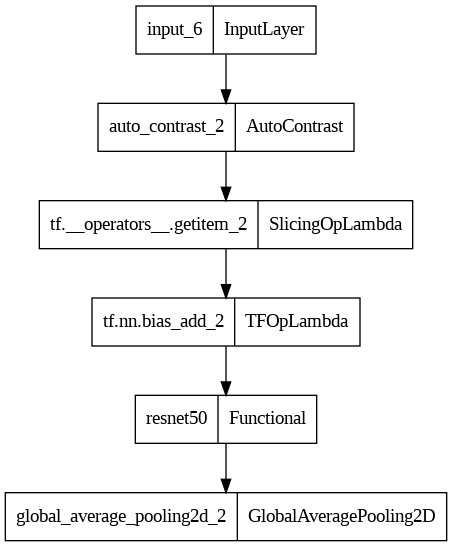

In [15]:
tf.keras.utils.plot_model(model)

## Realizando Inferencia

In [18]:
datasets =  train_generator, validation_generator, test_generator
filenames =  ["features_train_hist.json",
              "features_validation_hist.json",
              "features_test_hist.json"]


In [21]:
import pandas as pd
import os

for dataset, filename in zip(datasets, filenames):
  predictions = model.predict(dataset, verbose=1)
  datadict = {
    'features': [],
    'filepath': [],
  }
  for path, feature in zip(dataset.file_paths, predictions):
    datadict["filepath"].append(path)
    datadict["features"].append(feature)
  set_features = pd.DataFrame(datadict)
  if not os.path.exists(feature_filepath):
    os.mkdir(feature_filepath)
  set_features.to_json(f"{feature_filepath}/{filename}")




172/172 [==============================] - 85s 484ms/step
